# Execute DYN3D after reading & writing cross sections

This notebook mimics a scenario where cross sections are read from 2-dim files.

This Notebook demonestrates how to read cross sections from a serpent ``_res.m`` file, and write these cross sections using a template file.
In addition, this notebook shows how to execute DYN3D using the written cross sections.

## Case Description

The ``.\inputs`` directory includes:
- ``bwr_rho1_2gr`` a serpent input file. This is a 3D BWR assembly divided into 36 layers (i.e., universes 1,2,...,36) of fuel surrounded by a bottom (universe 54) and upper layers (universe 55) of reflectors. **However, only u22, u54, and u55 are read to mimic the active fuel and reflectors.** These cross sections are then used to define 38 axial layers.

- ``bwr_rho1_2gr_res.m`` a serpent results file with all the cross sections.
- ``univs`` a file that describes how to read ``bwr_rho1_2gr_res.m``
- ``template_dyn3d_2g`` is a template file that specifies how cross sections should be printed out.
- ``controlDict`` the main files that is required by the ``xsInterface``.

The ``.\dyn3d`` includes a pre-generated DYN3D case. The ``.\dyn3d\xs`` directory will include all the files with printed cross sections required by DYN3D.

### Required imports

In [1]:
from xsInterface.functions.main import Main

In [2]:
# a class required to execute DYN3D
from xsInterface.functions.dyn3d import DYN3D

In [3]:
# plotting capability
from xsInterface.functions.plotters import Plot1d

In [4]:
inputFile = ".\\inputs\\controlDict"

### Read the cross sections

In [5]:
# Reset the main object
xs = Main(inputFile)

... Reading control dict ...
<.\inputs\controlDict>



#### Read xs data without populating the templates

In [6]:
# readTemplate allows to read and populate data using the templates
xs.Read(readUniverses=True)

SERPENT Serpent 2.1.32 found in .\inputs\bwr_rho1_2gr_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


... Reading universe <u> ...
... Reading coe/_res.m file for hisotry <nom> ...


### Populate cross sections

In the ``".\\inputs\\controlDict"`` the user defined the core map used to populate the cross sections according to their channels and layers positions.

In our problem we have 1 channel and 38 axial layers.

**Define states**
These states must exist and be used to obtain the cross sections for different channels and layers.

In [7]:
nchs, nlayers = 1, 3
states = {
'history':[['nom']*nlayers]*nchs, 'time': [[0.0]*nlayers]*nchs, 'dens': [[700.]*nlayers]*nchs,}

**Populate core data**
built-in capability to populate the data according to the defined map including defining new variables not listed in the original ``univs`` file.
This is a **mandaory** step if the intent is to execute DYN3D.

In [8]:
volmanip = {'infflx': 'divide'}
xs.PopulateCoreData(
                    states=states, 
                    attributes=None,  # specify only if specific attrs needed
                    volManip=volmanip,
                    adf=None, topadf=None, bottomadf=None)

### Execute DYN3D

In [9]:
casedir = ".\\dyn3d"   # dyn3d dir
casefile = "bwr"  # name of dyn3d file
exefile = "RUN_DYN3D" # dyn3d executuin file

# Reset the object
reslt = DYN3D(xs, casedir, casefile, exefile)

**Execute**

The files will be written to the specified directories and then automatically executed.

In [10]:
reslt.Execute(printstatus=True)

... DYN3D Execution ... Start
... DYN3D Execution ... Ended Successfully


### Process results

In [11]:
# eigenvalue
reslt.keff

1.329169

In [12]:
# few-group flux
# reslt.flux

### Process results

In [13]:
import numpy as np

The layers are defined as they were used in the actual problem

In [14]:
layers = np.linspace(0, 365.76, 37)  #active core
layers = np.hstack((-20.0, layers, 385.76))  # with reflectors
zmid = 0.5*(layers[0:-1] + layers[1:])

**Plot** axial distribution

In [15]:
# flux obtained by DYN3D
dynFlux = np.array(reslt.flux)
fastFlux = dynFlux[0, :, 0] / np.sum(dynFlux[0, :, 0])
thermalFlux = dynFlux[0, :, 1] / np.sum(dynFlux[0, :, 1])

In [16]:
flx_profiles = {'Fast': dynFlux[0, :, 0],
          'Thermal': dynFlux[0, :, 1],}

Built-in 1-dim plotting capability

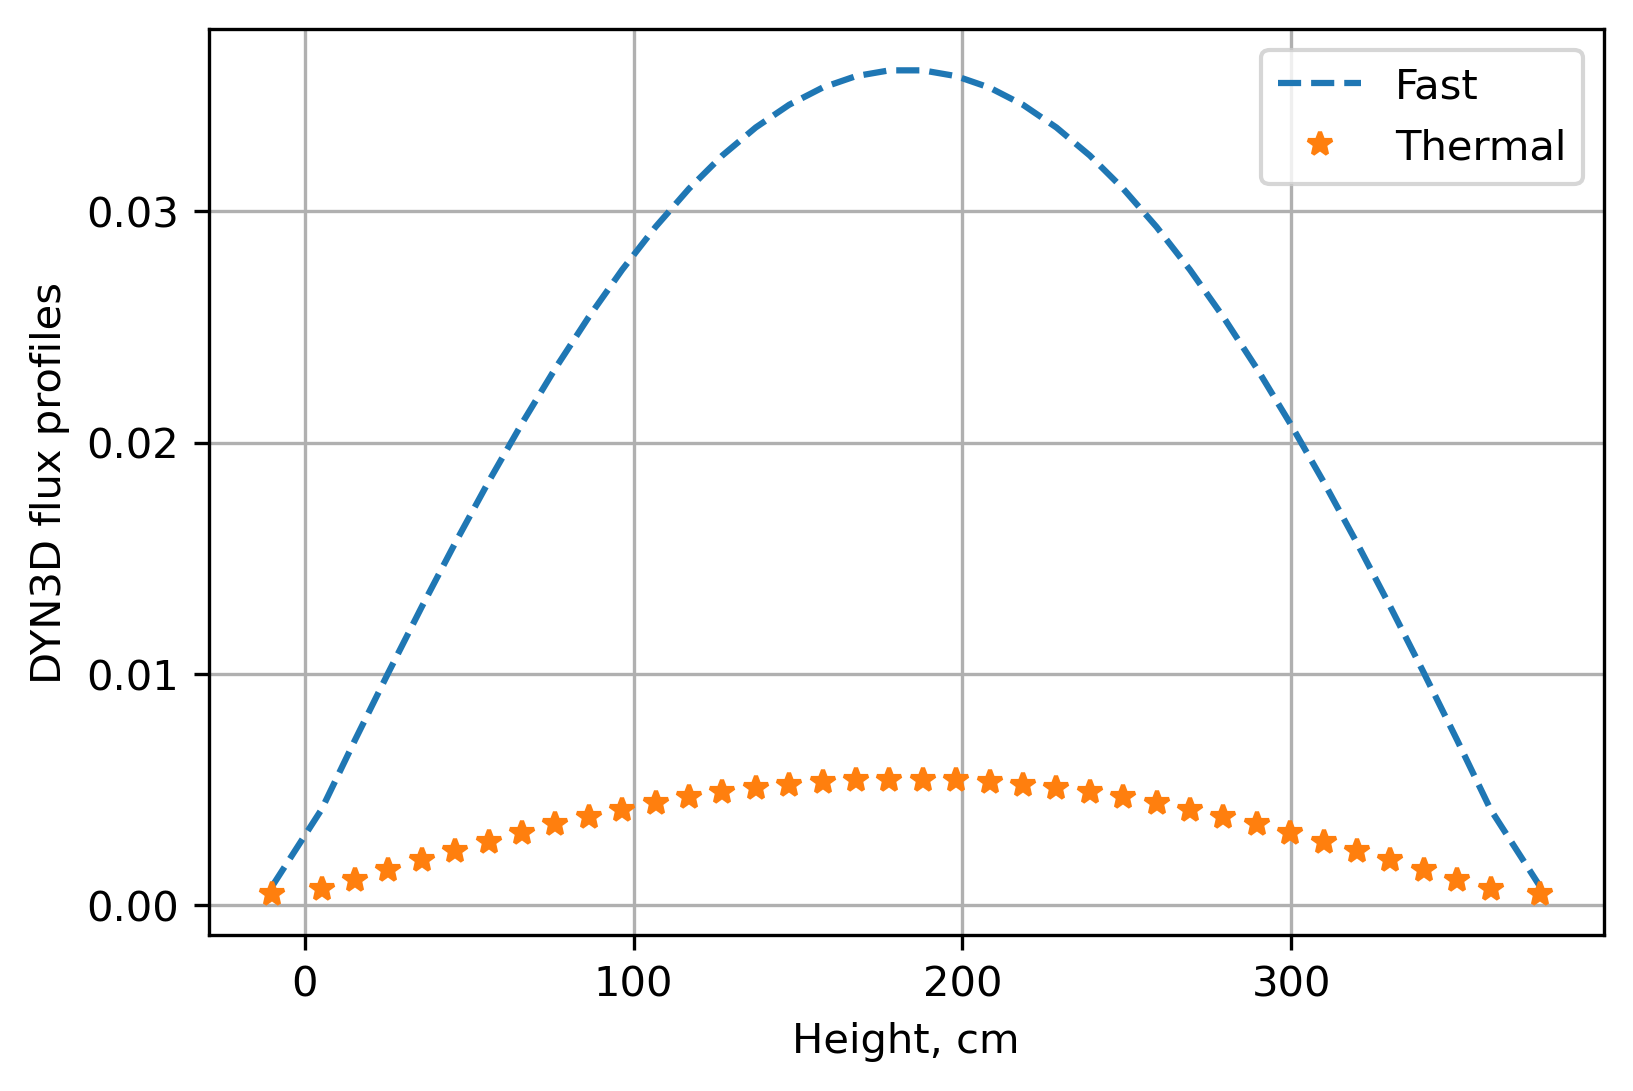

In [17]:
Plot1d(xvalues=zmid, yvalues=flx_profiles,
       markers=['--', '*'],
       xlabel="Height, cm", ylabel="DYN3D flux profiles")